week 3 | Groundwater

# Topic 3 : Modflow 

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti

In [ ]:
# Setting up the notebook
import sys
import os

# Import local libraries
sys.path.append('../../src')
from notebook_navigation import NotebookNavigation

# Create a NotebookNavigation object which can be printed at the end of the page
nav = NotebookNavigation(chapter_config_path='../../chapter_config.json')

# Content 
to be added to slides

How is the groundwater flow equation discretized and solved in MODFLOW?  
What are the implication of the discretization and solution method for the accuracy and efficiency of the model?  
How are boundary conditions implemented in MODFLOW?

Here: Quizzes to see if students understand
How to judge if a spatial discretization is accurate enough?
What are the implications of using a coarse grid?
What are the implications of using a fine grid?
What are the implications of using a coarse time step?
What are the implications of using a fine time step?
What is steady state flow?
What is transient flow?
...
How to decide how to implement recharge?
How to decide how to implement evapotranspiration?
Which boundary conditions are available in MODFLOW?
...

TODO: Load the Limmat Valley model

In [1]:
# package import
from tempfile import TemporaryDirectory
import flopy
temp_dir = TemporaryDirectory()
workspace = temp_dir.name
name = "tutorial01"

In [2]:
# set up simulation and basic packages
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=workspace)
flopy.mf6.ModflowTdis(sim, nper=10, perioddata=[[365.0, 1, 1.0] for _ in range(10)])
flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
botm = [30.0, 20.0, 10.0]
flopy.mf6.ModflowGwfdis(gwf, nlay=3, nrow=4, ncol=5, top=50.0, botm=botm)
flopy.mf6.ModflowGwfic(gwf)
flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.0], [(2, 3, 4), 0.0]])
budget_file = f"{name}.bud"
head_file = f"{name}.hds"
flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=budget_file,
    head_filerecord=head_file,
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print("Done creating simulation.")

Done creating simulation.


In [3]:
# The verbosity level, which determines how much FloPy writes to command line output. The options are 1 for quiet, 2 for normal, and 3 for verbose. Below we set the verbosity level to verbose.
sim.simulation_data.verbosity_level = 3
#We can also set the number of spaces to indent data when writing package files by setting the indent string.
sim.simulation_data.indent_string = "    "
#Next we set the precision and number of characters written for floating point variables.
sim.float_precision = 8
sim.float_characters = 15
#Lastly, we disable verify_data and auto_set_sizes for faster performance. With these options disabled FloPy will not do any checking or autocorrecting of your data.
sim.verify_data = False
sim.auto_set_sizes = False

In [ ]:
print(sim)

sim_name = tutorial01
sim_path = /var/folders/fx/fhbs7qgd6998fvtd5n8bs1lr0000gn/T/tmpc6hys2_w
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = tutorial01


###################
Package tutorial01.tdis
###################

package_name = tutorial01.tdis
filename = tutorial01.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = tutorial01


###################
Package ims_-1
###################

package_name = ims_-1
filename = tutorial01.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = tutorial01


@@@@@@@@@@@@@@@@@@@@
Model tutorial01
@@@@@@@@@@@@@@@@@@@@

name = tutorial01
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package dis
###################

package_name = dis
filename = tutorial01.dis
package_type = dis
model_or_simulation_package = mo

Modflow2005 test
source: https://ngwa.onlinelibrary.wiley.com/doi/epdf/10.1111/gwat.12413?saml_referrer

In [7]:
import numpy as np
import flopy.modflow as fpm
import flopy.utils as fpu

model = fpm.Modflow(modelname = 'gwexample')

fpm.ModflowDis(model, nlay=1, nrow=1, ncol=201, delr=10, delc=1, top=50, botm=0)

ibound = np.ones((1, 201))
ibound[0, 0] = ibound[0, -1] = -1
fpm.ModflowBas(model, ibound=ibound, strt=20)

fpm.ModflowLpf(model, hk=10, laytyp=1)

fpm.ModflowRch(model, rech=0.001)
lrcQ = { 0: [[0, 0, 50, -1], [0, 0, 150, -1]]}
fpm.ModflowWel(model, stress_period_data=lrcQ)

fpm.ModflowPcg(model)

fpm.ModflowOc(model)

model.write_input()

model.run_model()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: gwexample.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/02/03 15:56:01

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/03 15:56:01
 Elapsed run time:  0.002 Seconds

  Normal termination of simulation


(True, [])

In [10]:
hfile = fpu.HeadFile('gwexample.hds')
h = hfile.get_data(totim=1.0)

print(h.shape)


(1, 1, 201)


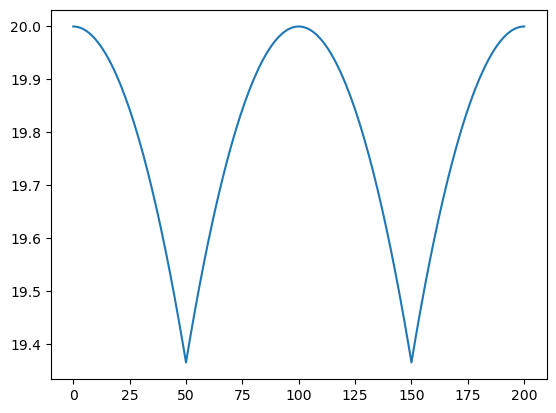

In [14]:
# shape of h is (1, 1, 201)
# Plot h
import matplotlib.pyplot as plt
plt.plot(h[0, 0, :])
plt.show()

[<Axes: title={'center': ' model_top'}>,
 <Axes: title={'center': 'botm layer 1'}>]

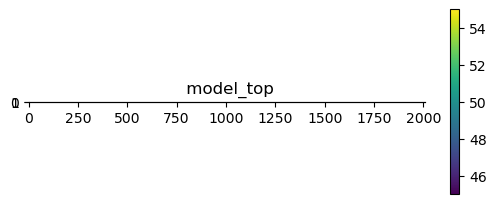

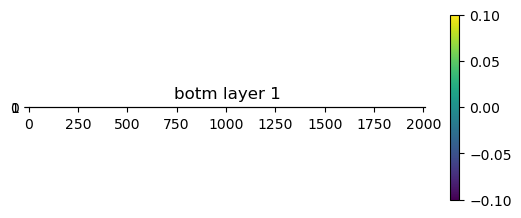

In [16]:
# The discretization of my model is this:
# fpm.ModflowDis(model, nlay=1, nrow=1, ncol=201, delr=10, delc=1, top=50, botm=0)
# Plot the model grid
model.dis.plot()

In [ ]:
nav.display_navigation('modflow')